<a href="https://colab.research.google.com/github/6namdang/MedicalLLM-Finetuning/blob/main/finetune_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install tiktoken
import tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.8 MB/s eta 0:00:00


In [140]:
from google.colab import files
uploaded = files.upload()

Saving medical_reports.csv to medical_reports.csv


In [173]:
df = pd.read_csv("reports.csv")

In [142]:
df.info() #i want to see if the counts are missing or not

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  4999 non-null   object
 1   report             4966 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [174]:
df = df.dropna(subset=['report'])

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [176]:
df.groupby(['medical_specialty']).count()

,report
medical_specialty,
Cardiovascular / Pulmonary,371
Gastroenterology,224
Neurology,223
Radiology,273
Surgery,1088


In [177]:
grouped_data = df.groupby(['medical_specialty']).sample(110,random_state=1234)

In [178]:
val_datasets= grouped_data.groupby(['medical_specialty']).sample(10, random_state=1234)

In [179]:
val = val_datasets.groupby(['medical_specialty']).head(5)

In [180]:
test = val_datasets.groupby(['medical_specialty']).tail(5)

In [181]:
train = grouped_data[~grouped_data.index.isin(val_datasets.index)]

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 2104 to 512
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  500 non-null    object
 1   report             500 non-null    object
dtypes: object(2)
memory usage: 11.7+ KB


In [184]:
def numbers_of_tokens(string):
  encoding = tiktoken.get_encoding("cl100k_base")
  num_tokens = len(encoding.encode(string))
  return num_tokens

In [185]:
numbers_of_tokens("fbewhfbwefuyweyfgeyweyuwevfitwifewytfyewbfwebfbybfywegfwe7346564735667345374657358fhwfw")

45

In [186]:
train_report_token_length = train['report'].apply(numbers_of_tokens)

In [187]:
test_report_token_length = test['report'].apply(numbers_of_tokens)

In [127]:
val_report_token_length = val['report'].apply(numbers_of_tokens)

In [40]:
#on the left is the target on the right is the features
val_report_token_length

,report
2161,486
2159,1180
1850,530
2047,249
2006,656
1881,660
1930,1462
1879,1130
1996,346
1974,676


In [188]:
system_prompt = "Given a report description, classify medical specialty into Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

In [189]:
print(system_prompt)

Given a report description, classify medical specialty into Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery


In [202]:
def df_to_format(df):
    formatted_data = []
    for index, row in df.iterrows():
        entry = {
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": row['report']},
                {"role": "assistant", "content": row['medical_specialty']}
            ]
        }
        formatted_data.append(entry)  # Ensure this is inside the loop
    return formatted_data

In [191]:
print(df_to_format(train))

[{'messages': [{'role': 'system', 'content': 'Given a report description, classify medical specialty into Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'}, {'role': 'user', 'content': "PREOPERATIVE DIAGNOSIS:,  Right inguinal hernia.,POSTOPERATIVE DIAGNOSIS: , Right inguinal hernia.,ANESTHESIA: , General.,PROCEDURE:  ,Right inguinal hernia repair.,INDICATIONS: , The patient is a 4-year-old boy with a right inguinal bulge, which comes and goes with Valsalva standing and some increased physical activity.  He had an inguinal hernia on physical exam in the Pediatric Surgery Clinic and is here now for elective repair.  We met with his parents and explained the surgical technique, risks, and talked to them about trying to perform a diagnostic laparoscopic look at the contralateral side to rule out an occult hernia.  All their questions have been answered and they agreed with the plan.,OPERATIVE FINDINGS:  ,The patient had a well developed, but rather thin walled 

In [34]:
import json

In [203]:
fine_tune_train= df_to_format(train)

In [204]:
#create a jsonfile for entry
with open('fine_tune_medical_dataset.json', 'w') as f:
  for entry in fine_tune_train:
    f.write(json.dumps(entry))
    f.write("\n")

In [205]:
fine_tune_val= df_to_format(val)

In [206]:
with open('fine_tune_val_medical_dataset.json', 'w') as f:
  for entry in fine_tune_val:
    f.write(json.dumps(entry))
    f.write("\n")

In [50]:
import os

In [51]:
!pip install openai

In [53]:
import openai

In [197]:
from openai import OpenAI

In [207]:
file_upload_response = client.files.create(file= open('fine_tune_medical_dataset.json','rb'), purpose = 'fine-tune')

In [208]:
file_upload_response_val = client.files.create(file=open('fine_tune_val_medical_dataset.json','rb'), purpose='fine-tune')

In [209]:
fine_tuning_response = client.fine_tuning.jobs.create(training_file=file_upload_response.id,
                                                      model='gpt-3.5-turbo-0125',
                                                      hyperparameters={'n_epochs':1},
                                                      validation_file=file_upload_response_val.id
                                                      )

In [72]:
print(fine_tuning_response)

FineTuningJob(id='ftjob-UMQlo7YrKgPLtOPvbjZdsF6q', created_at=1731451691, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-UskPvm5tQBo6f1JHMgh9uziW', result_files=[], seed=1908777240, status='validating_files', trained_tokens=None, training_file='file-VvvpQMlstGuIl3cZefuV2Bld', validation_file='file-OMvpIDZMWTTb03bnoT4ejPYT', estimated_finish=None, integrations=[], user_provided_suffix=None)


In [210]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-Xu9HDTsALmbrjqWyGcis8mlJ', created_at=1731453978, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::ASuoKKnx', finished_at=1731454927, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-UskPvm5tQBo6f1JHMgh9uziW', result_files=['file-duoskMLt92Amhx679aI0CiJm'], seed=2047360041, status='succeeded', trained_tokens=355635, training_file='file-CEMwoxVQKKSQ5i9K8VHKp8IT', validation_file='file-auRJU0XcUYo9lmRx7VAXhscC', estimated_finish=None, integrations=[], user_provided_suffix=None)], object='list', has_more=True)

In [213]:
training_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-Xu9HDTsALmbrjqWyGcis8mlJ")

In [214]:
training_event.data

[FineTuningJobEvent(id='ftevent-BIK4JYjWHD8z8g0IZtLUs7xI', created_at=1731454932, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-KDnxjgQmgVBwLD6zK5hpbWY4', created_at=1731454929, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-D7beZADjn82rfHaVYKRPbZYn', created_at=1731454917, level='info', message='Step 500/500: training loss=0.00, validation loss=0.00, full validation loss=0.50', object='fine_tuning.job.event', data={'step': 500, 'train_loss': 4.76837158203125e-07, 'valid_loss': 1.9073486328125e-06, 'total_steps': 500, 'full_valid_loss': 0.5003576914469401, 'train_mean_token_accuracy': 1.0, 'valid_mean_token_accuracy': 1.0, 'full_valid_mean_token_accuracy': 0.9481481481481482}, type='metrics'),
 FineTuningJobEvent(id='ftevent-tOsrTgJjFMQ1eMTpW69XPZES', created_at=1731454915, level='info', 

In [215]:
train_loss = []
val_loss = []

In [221]:
# Ensure that the lists are initialized before the loop
train_loss = []
val_loss = []

# Loop through the event data
for item in training_event.data:
    train_data = item.data
    if train_data:
        # Add train_loss if the key exists
        if 'train_loss' in train_data:
            train_loss.append(train_data['train_loss'])  # Use append() instead of insert()

        # Add valid_loss if the key exists
        if 'valid_loss' in train_data:
            val_loss.append(train_data['valid_loss'])  # Use append() instead of insert()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

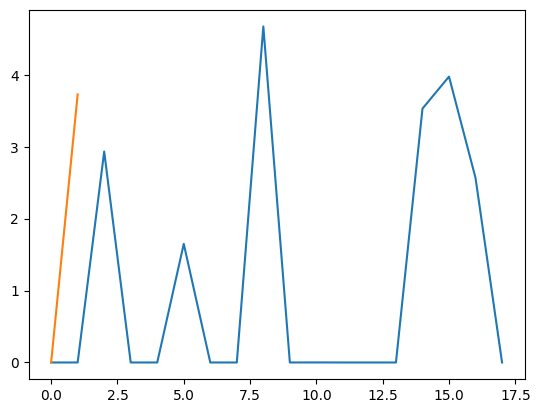

In [224]:
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

In [228]:
def finetuneReport(report, model):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": report}
        ]
    )
    return completion

In [232]:
(np.array(predicted_class) == np.array(ground_truth_class)).mean()

0.04

In [233]:
predicted_class=[]
ground_truth_class=[]

for row in test.iterrows():
  report,speciality=row[1]['report'],row[1]['medical_specialty']
  ground_truth_class.append(speciality.strip())
  prediction = finetuneReport(report, model='ft:gpt-3.5-turbo-0125:personal::ASuoKKnx')
  predicted_class.append(prediction.choices[0].message.content.strip())

In [234]:
(np.array(predicted_class) == np.array(ground_truth_class)).mean()

0.8

In [ ]:
#20% better than gpt-3.5